# Computing fractal dimension of strange attractor in Lorenz sytstem


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math as math
from tqdm import tqdm
from scipy import integrate
from scipy.linalg import expm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
#Documentation: https://nolds.readthedocs.io/en/latest/nolds.html#correlation-dimension
import nolds


## Simulating the system

In [4]:
#parameters of the system
rho = 28
sigma = 10
beta =8/3

#Initial condition
state0 = np.array([-8, -8, 27])

def difeq(data,t):
    '''System of differential eqautions'''
    x,y,z=data
    xp=sigma*(y-x)
    yp=x*(rho-z)-y
    zp=x*y-beta*z
    return [xp,yp,zp]

dt=0.01
T=10000*dt
discard_t = 100
T_total = T+discard_t
t=np.arange(0,T_total,dt)
data=integrate.odeint(difeq,state0,t)[int(discard_t/dt):]
N=len(data)
#Data along X
Xdata=data[:,0]

## Function computing correlation dimension

In [5]:
def get_corrdim(timeseries,rmin,rmax,rpoints=100):
    N=len(timeseries)
    distmat=np.zeros((N,N))
    for i in range(N):
        distmat[i,:]=np.linalg.norm(timeseries[i,:]-timeseries,axis=1)
    rval=2**(np.linspace(rmin,rmax,rpoints))
    corval=np.zeros(rpoints)
    for rm,r in tqdm(enumerate(rval)):
        #Compute the number of close neighbours (excluding the point itself)
        corval[rm]=sum(x<r for x in distmat).sum()-1
    return corval,rval

## Correlation dimension from phase space

100it [00:11,  8.63it/s]

2.0015516894334153


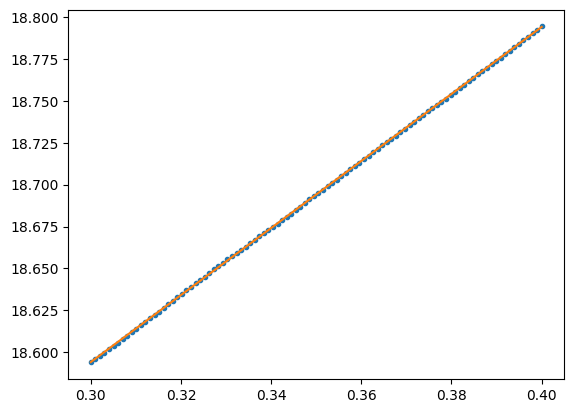

In [6]:
corval,r=get_corrdim(data,rmin=0.3,rmax=0.4)
fit=np.polyfit(np.log2(r),np.log2(corval),1)
print(fit[0])
plt.figure()
plt.plot(np.log2(r),np.log2(corval),'.')
plt.plot(np.log2(r),np.polyval(fit,np.log2(r)))


using python nolds module as reference

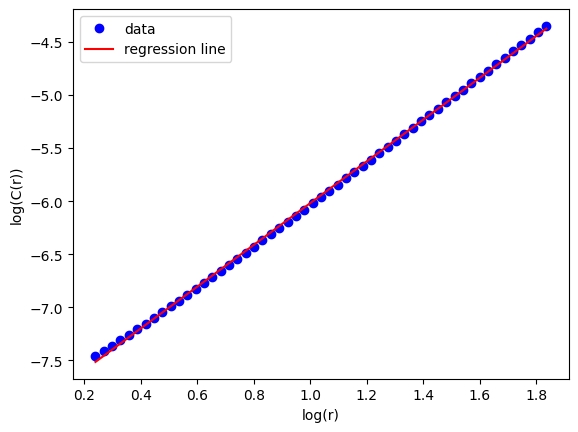

1.9693733351606657

In [8]:
nolds.corr_dim(data[:,0],6,debug_plot=True)

## Embeded time series data 


In [8]:
def getLag(tseries,m,tau=1):
    '''Input: Lag step tau ( = distance between lags),
    m = dimension of lag vector, tseries = time series data'''
    lengthY=tseries.shape[0]
    Ncolumns=m
    Nrows=math.ceil(lengthY/tau)-Ncolumns+1
    x=np.zeros([Nrows,Ncolumns])
    for k in range(Nrows):
        #Constructing the lag vector 
        xk=tseries[tau*k::tau]
        
        #Broadcasting them into same shape
        xk=np.array(xk[0:Ncolumns])
        x[k,:]=xk
    return x

def whitening(X):
    '''Does the ICA'''
    #Subtracting the mean of each column
    Xmean=np.mean(X,axis=0)
    X_centered = X-Xmean
    
    Sigma=np.dot(X_centered.T, X_centered) / X_centered.shape[0]
    modes, Lambda, V = np.linalg.svd(Sigma)
    W = np.dot(np.diag(1.0 / np.sqrt(Lambda + 1e-5)), modes.T) #we add a regularizing term
    return modes,Xmean,W,np.dot(X_centered, W.T)

def invert_transform(phspace,w,xmean):
    '''Inverts the ICA'''
    if len(phspace.shape)>1:
        m = phspace.shape[1]
    else: 
        m = phspace.shape[0]
    return phspace.dot(np.linalg.pinv(w[:m,:].T))+xmean

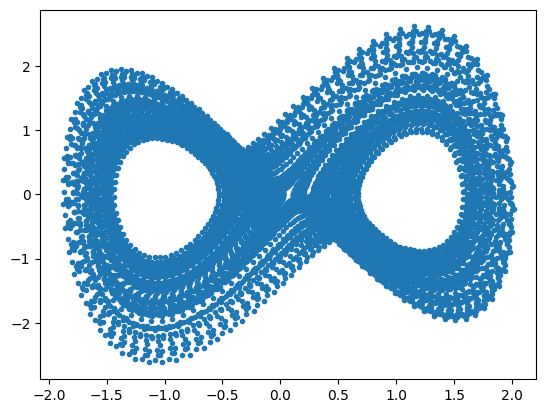

In [9]:
mmin=3
K=20
Lagmat=getLag(Xdata,K)
modes,xmean,w,XICA_all=whitening(Lagmat)
X=XICA_all[:,:mmin]
plt.figure()
plt.plot(X[:,0],X[:,1],'.')

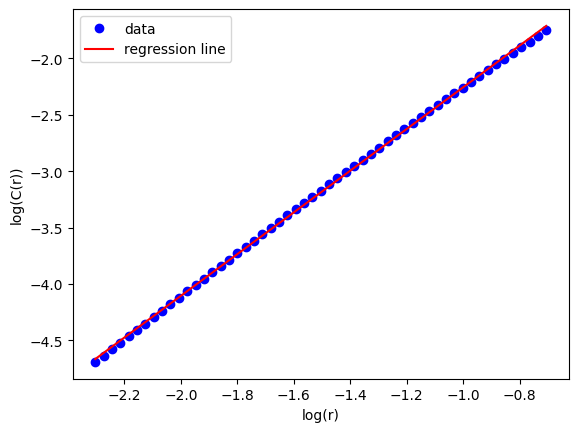

1.8501541947405107

In [56]:
nolds.corr_dim(X,6,debug_plot=True)

In [23]:
corval,r=get_corrdim(X,rmin=0.1,rmax=3)

100it [00:11,  8.68it/s]


1.648019476448935


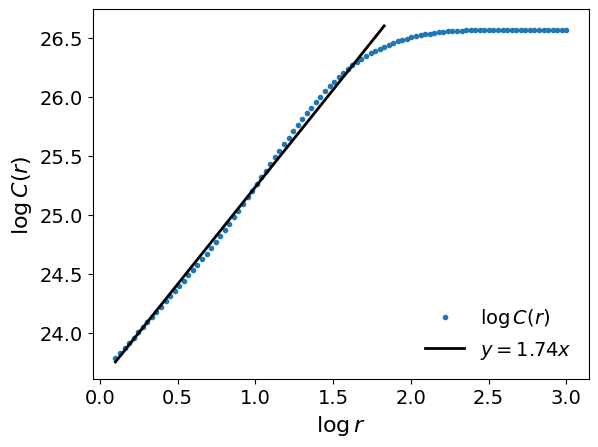

In [27]:
rfit=-40
fit=np.polyfit(np.log2(r[0:rfit]),np.log2(corval[0:rfit]),1)
print(fit[0])

fig, ax = plt.subplots()
plt.plot(np.log2(r),np.log2(corval),'.',label=r'$\log C(r)$')
plt.plot(np.log2(r[0:rfit]),np.polyval(fit,np.log2(r[0:rfit])),'k',linewidth=2,label=r'$y=1.74x$')
plt.legend(loc='lower right',frameon=False,fontsize=14)
plt.xlabel(r'$\log r$',fontsize=16)
plt.ylabel(r'$\log C(r)$',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
#fig.savefig('CorrelationDimension.png', format='png ', dpi=600,bbox_inches='tight')
plt.show()


## Kaplan-Yorke dimension

### From embedding exponents

In [35]:
Exponents=np.array([1.56817004, -4.3932767*10**(-3),-1.46900272e+01])
#Kaplan-York dimension (https://mathworld.wolfram.com/Kaplan-YorkeDimension.html)
D=2+(Exponents[0]+Exponents[1])/np.abs(Exponents[2])
print("Kaplan-Yorke Dimension : ",D)

Kaplan-Yorke Dimension :  2.1064515907295256


### From exponents computed with known Jacobian

In [2]:
Exponents=np.array([1.50173858e+00, 2.67208489e-05,-2.25017233e+01])
#Kaplan-York dimension (https://mathworld.wolfram.com/Kaplan-YorkeDimension.html)
D=2+(Exponents[0]+Exponents[1])/np.abs(Exponents[2])
print("Reference Kaplan-Yorke Dimension : ",D)

Reference Kaplan-Yorke Dimension :  2.0667400127904383
